In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

from xgboost import cv

import matplotlib.pyplot as plt
import plotly
import seaborn as sns

In [2]:
# Import data

houseprice_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
houseprice_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
# Information about data

houseprice_train.info()
houseprice_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# show some rows

houseprice_train.head(5)
# houseprice_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# understand the data (Know features)

houseprice_X = pd.concat([houseprice_train.drop("SalePrice", axis=1),houseprice_test], axis=0)
houseprice_Y = houseprice_train[['SalePrice']]


houseprice_numeric = houseprice_X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
houseprice_numeric.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [6]:
# Exploring data:

houseprice_train_cols = houseprice_train.columns

houseprice_num = houseprice_train._get_numeric_data().columns
houseprice_num = [i for i in houseprice_num if i not in ('OverallQual','OverallCond')]




cat_train_houseprice = houseprice_X.select_dtypes(include=['object']).copy()
cat_train_houseprice['MSSubClass'] = houseprice_X['MSSubClass']   #MSSubClass is nominal
cat_train_houseprice.columns
cat_houseprice = list(set(houseprice_train_cols) - set(houseprice_train_cols))

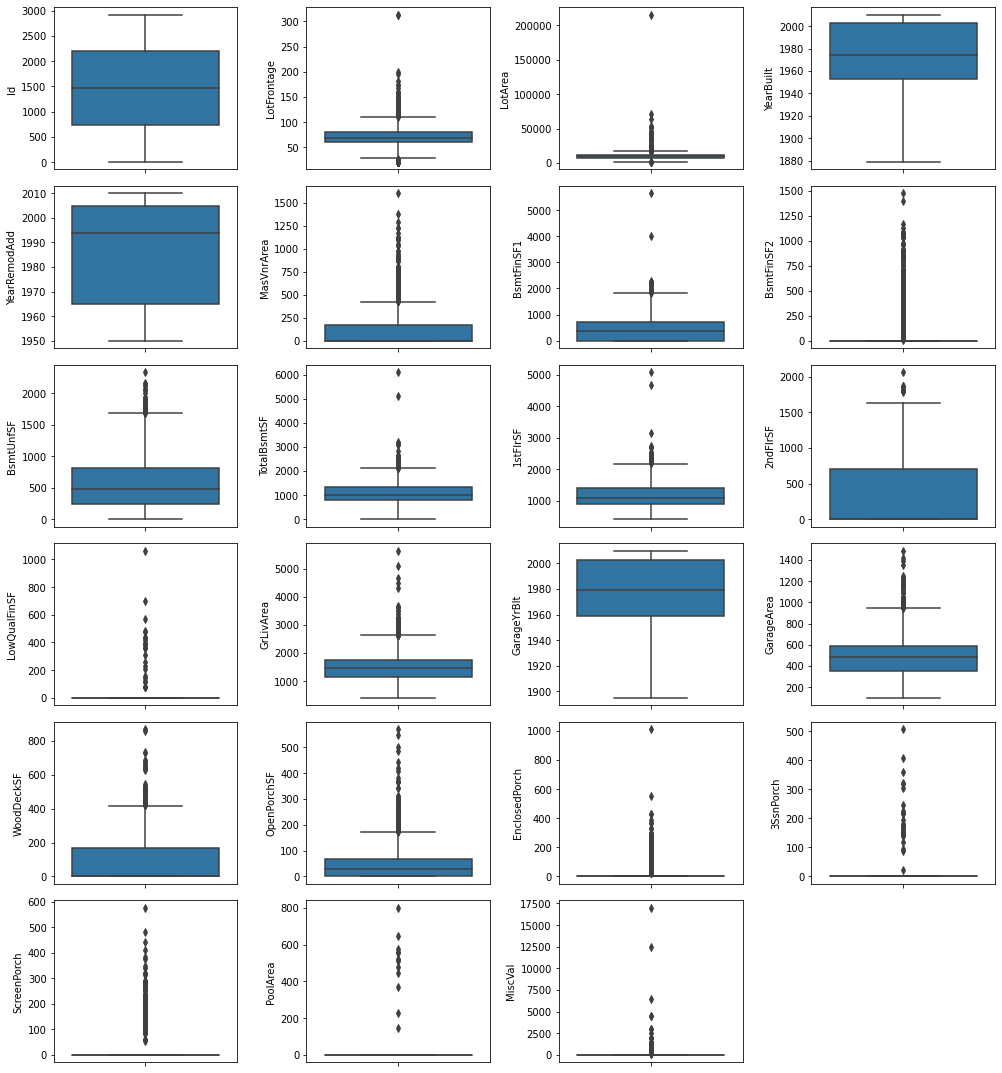

In [7]:
disc_number = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont = []
for i in houseprice_numeric.columns:
    if i not in disc_number:
        cont.append(i)



fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=houseprice_numeric.dropna())
fig.tight_layout(pad=1.0)

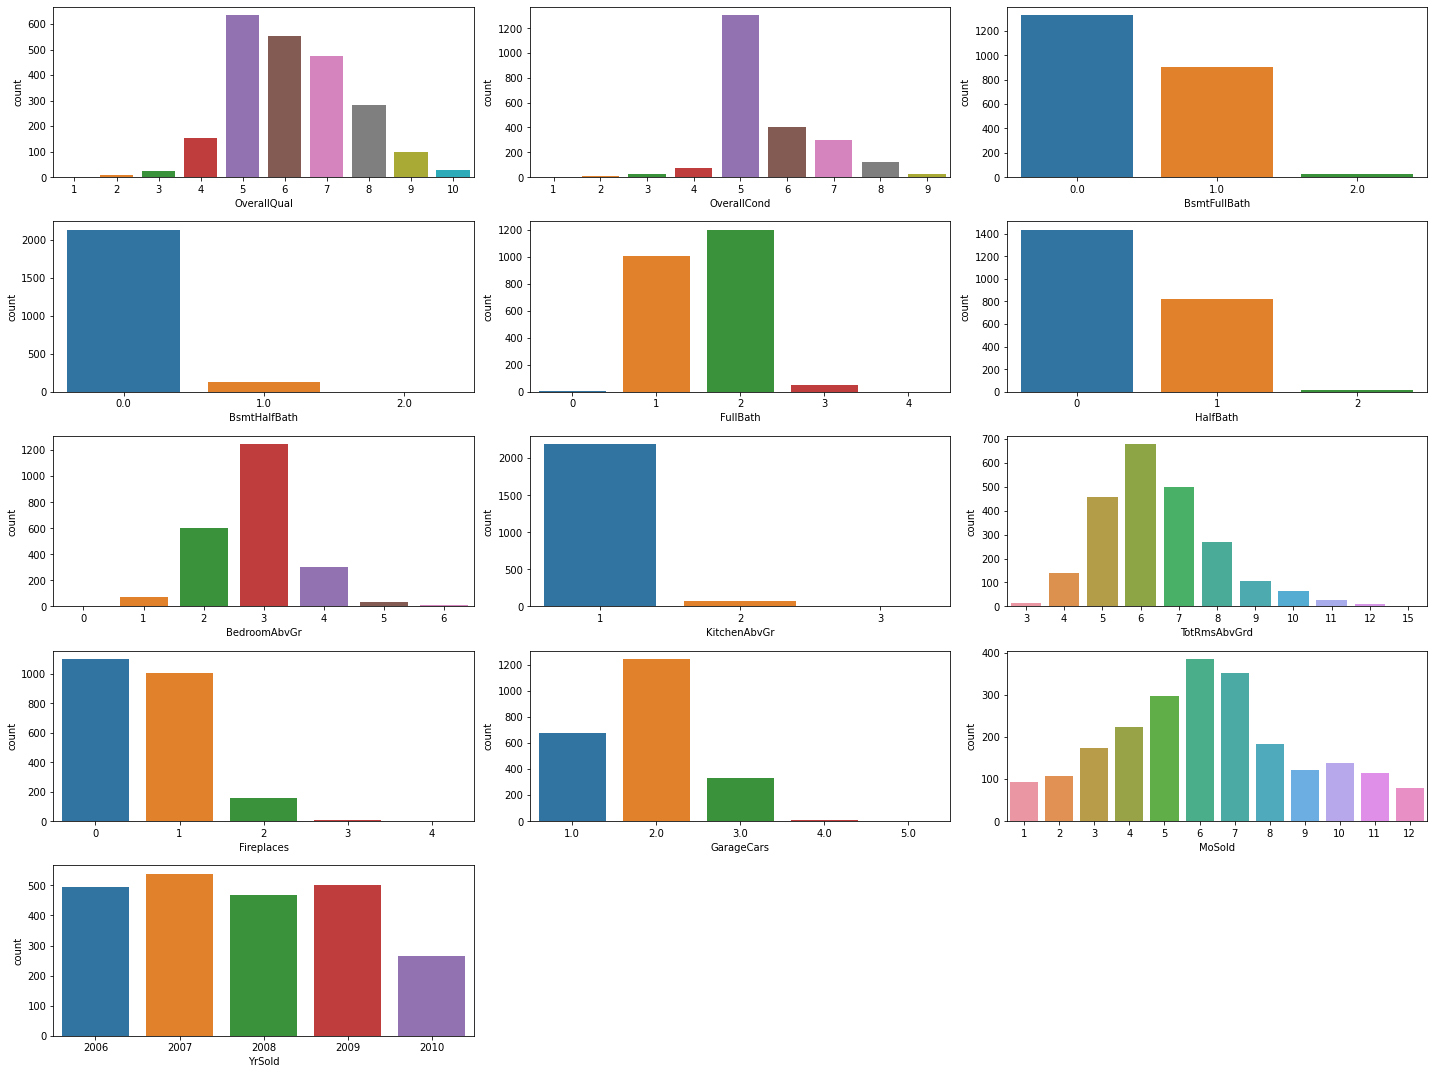

In [8]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_number):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=houseprice_numeric.dropna())
fig.tight_layout(pad=1.0)

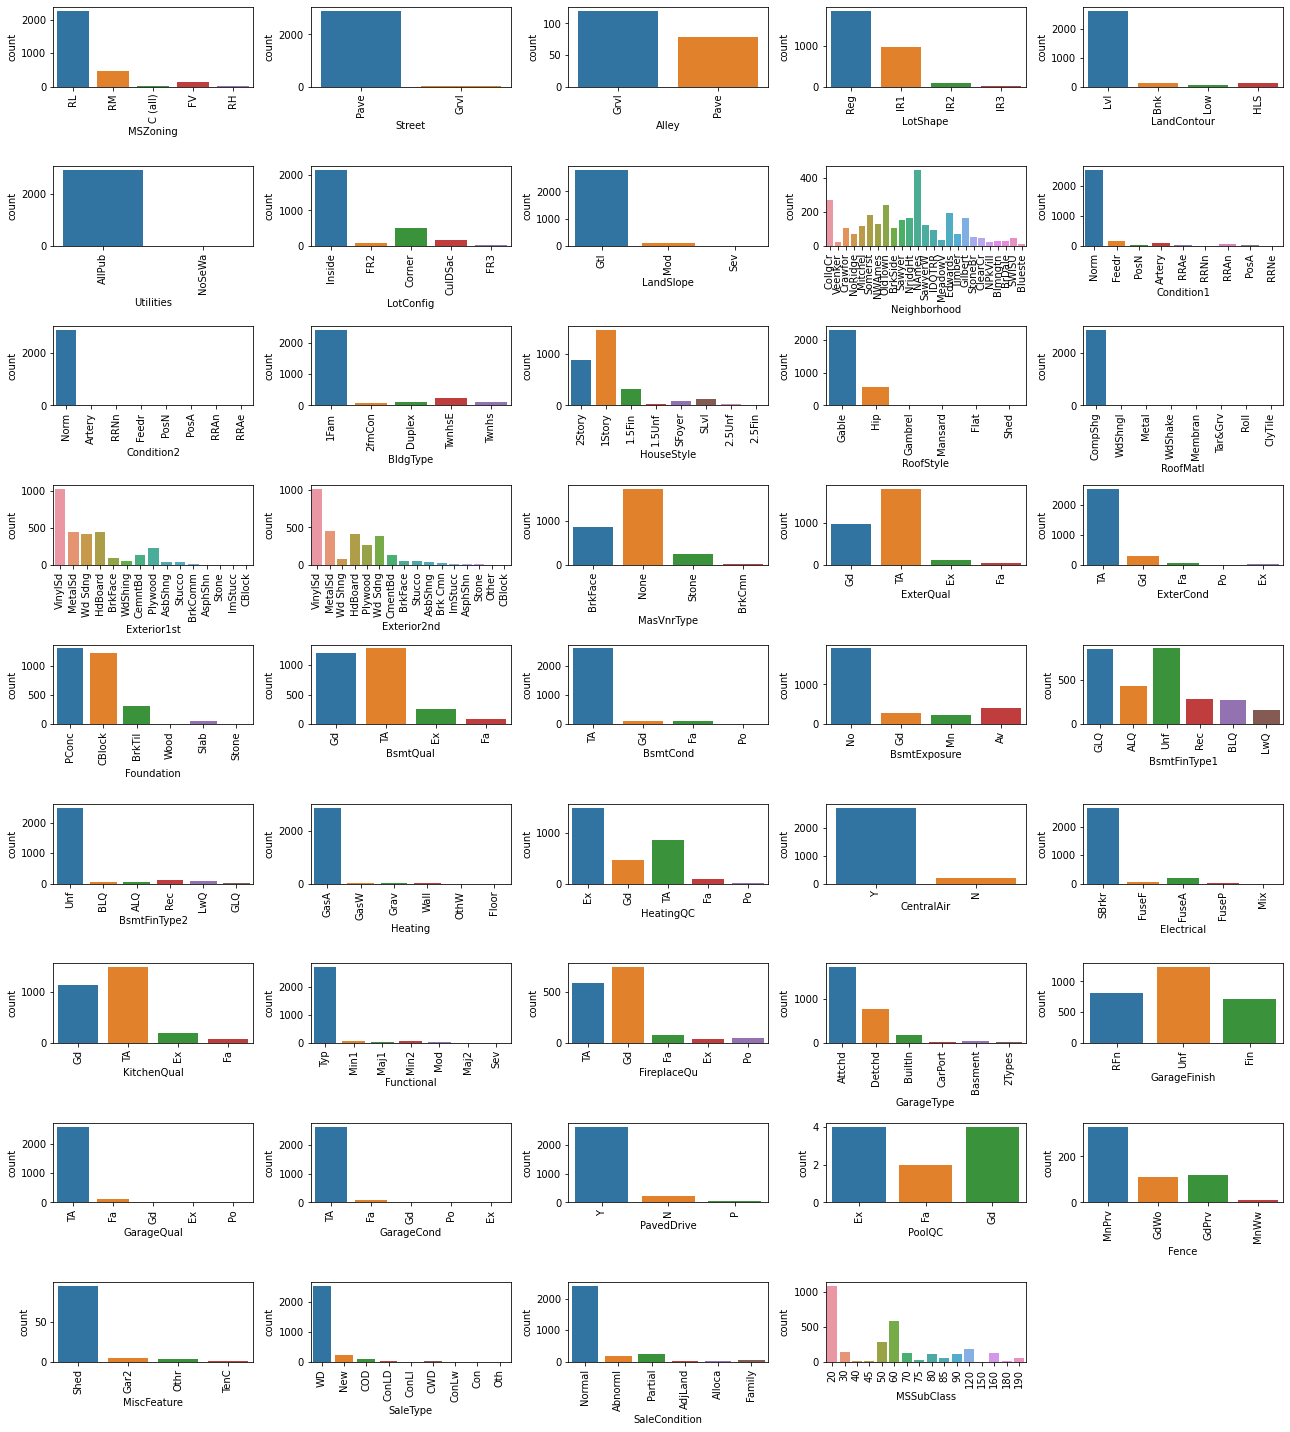

In [9]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train_houseprice.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train_houseprice.iloc[:,index], data=cat_train_houseprice.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

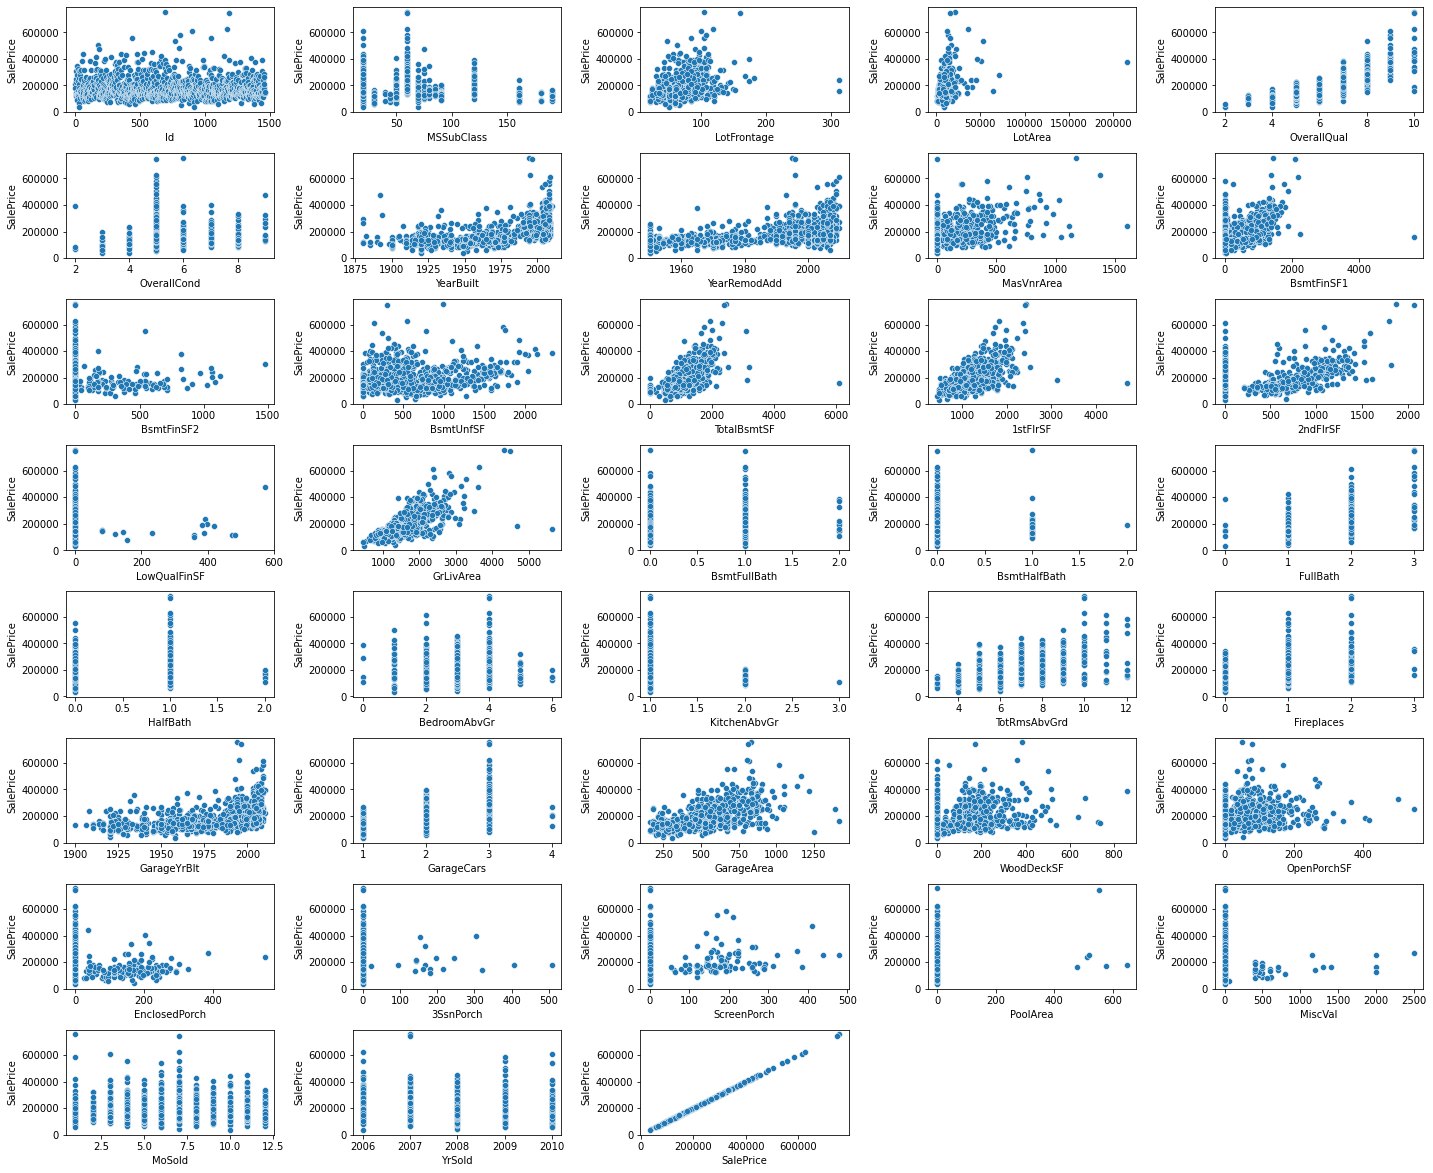

In [10]:

houseprice_numeric_train = houseprice_train.select_dtypes(exclude=['object'])
correlat_houseprice = houseprice_numeric_train.corr()
correlat_houseprice[['SalePrice']].sort_values(['SalePrice'], ascending=False)


fig = plt.figure(figsize=(20,20))
for index in range(len(houseprice_numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=houseprice_numeric_train.iloc[:,index], y='SalePrice', data=houseprice_numeric_train.dropna())
fig.tight_layout(pad=1.0)

<AxesSubplot:>

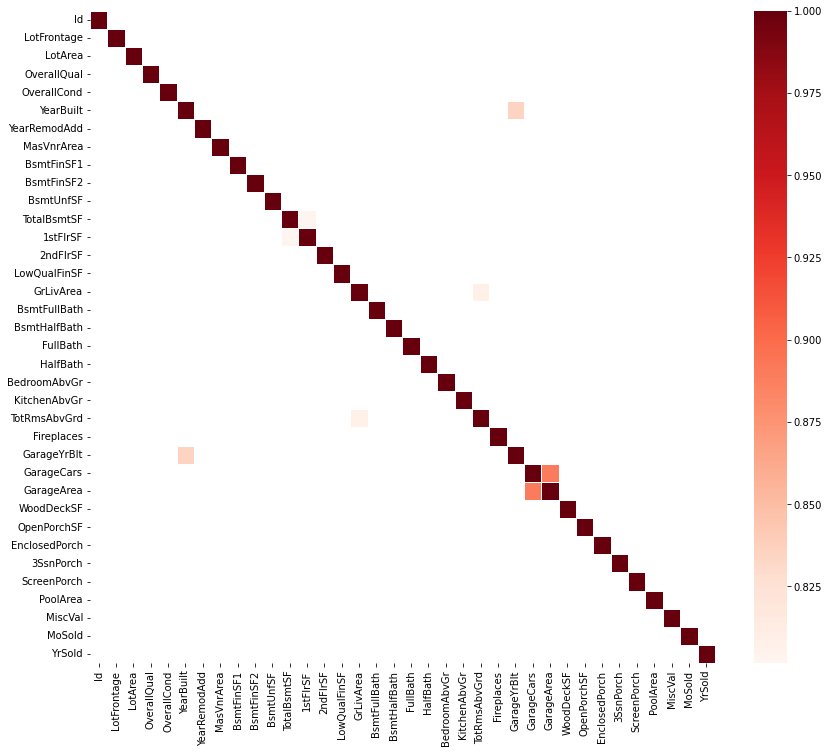

In [11]:
plt.figure(figsize=(14,12))
correlat_houseprice = houseprice_numeric.corr()
sns.heatmap(correlat_houseprice, mask = correlat_houseprice <0.8, linewidth=0.5, cmap='Reds')

In [12]:
# Data Preprocessing
# Redundant and useless features


correlat_houseprice = houseprice_numeric.corr()

houseprice_X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True) 

houseprice_X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

houseprice_X.drop(['MoSold','YrSold'], axis=1, inplace=True)

In [13]:
# Outliers

houseprice_train = houseprice_train.drop(houseprice_train[houseprice_train['LotFrontage'] > 200].index)
houseprice_train = houseprice_train.drop(houseprice_train[houseprice_train['LotArea'] > 100000].index)
houseprice_train = houseprice_train.drop(houseprice_train[houseprice_train['BsmtFinSF1'] > 4000].index)
houseprice_train = houseprice_train.drop(houseprice_train[houseprice_train['TotalBsmtSF'] > 5000].index)
houseprice_train = houseprice_train.drop(houseprice_train[houseprice_train['GrLivArea'] > 4000].index)


In [14]:
# convert the categorical columns

houseprice_X = pd.get_dummies(houseprice_X)
houseprice_Y["SalePrice"] = np.log(houseprice_Y['SalePrice'])

In [15]:
# XGBoost

houseprice_x = houseprice_X.loc[houseprice_train.index]
houseprice_Y = houseprice_Y.loc[houseprice_train.index]
test = houseprice_X.loc[houseprice_test.index]


In [16]:
cols = houseprice_x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(houseprice_x[cols])
houseprice_x[cols] = transformer.transform(houseprice_x[cols])
test[cols] = transformer.transform(test[cols])

In [17]:
# houseprice_y = houseprice_Y
houseprice_xx = houseprice_x
houseprice_xx.drop(houseprice_xx.tail(1449).index,inplace=True)
houseprice_xx = houseprice_xx[:-1]




# houseprice_yx
houseprice_xx.shape
# houseprice_Y.shape



X_train, X_val, y_train, y_val = train_test_split(houseprice_xx,houseprice_Y, test_size=0.2, random_state=2020)

In [18]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [19]:
param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 10, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)

In [20]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean




xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, houseprice_xx, houseprice_Y)
cv_xgb

-0.1748675475041123

In [21]:
def blend_models_predict(X, b):
        return b* xgb.predict(X)

In [22]:
blend_models_predict(test, 0.40)

array([4.887986 , 4.8404346, 4.9050264, ..., 4.7665706, 4.8037105,
       4.7567167], dtype=float32)